# Sound Classification

The goal of this project is to build a model that accurately classifies various sounds. The classes included are i) Speech ii) Music iii) Animal iv) Vehicle V) Natural Sounds. I went about this in two ways, 1. Using spectrogram images to train a convolutional neural network. 2. extracting numerical features, such as tempo, Mel-frequency cepstral coefficients (MFCCs), chroma features, and spectral features, from the audio files and trained various classification models.

In [239]:
#import relevant packages
import pandas as pd
import numpy as np
from scipy import stats
import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,RocCurveDisplay
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import itertools
from collections import Counter
import re

from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

import librosa
import librosa.display
from librosa import display

from PIL import Image
import os

In [64]:
#set a seed to use for random_state inputs for reproducability
SEED = 42

## Import Data

Please refer to the 'Audio_Pull' notebook to see how dataset was compiled from the public AudioSet data 
and how audio clips were downloaded
Please refer to the 'Spectrogram_Build' notebook to see how spectrograms were created
Please refer to 'Feature_Extraction' notebook to see how features were extracted from audio files

#### 1. Spectrogram Images

Spectrogram images were created and saved down in the 'Spectrogram_Build' Notebook. Here, I import these images and classification labels.

In [224]:
#In downloading audio and creating spectrograms, some files resulted in an empty audio file and blank, white spetrogram
#This function is designed to filter out any empyty/blank data points
def is_blank_image(image, threshold=0.99):
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Calculate the mean pixel value
    mean_pixel_value = np.mean(image_array)
    # Check if the mean pixel value is below the threshold
    return mean_pixel_value > threshold



In [225]:
#Import images
image_folder_128 = 'specs_sounds_128'
image_files = [file for file in os.listdir(image_folder_128) if file.lower().endswith(('.png'))]


labels = []
images = []

for file in image_files:
    image = Image.open(os.path.join(image_folder_128, file)).convert('RGB').resize((128, 128))
    image = np.array(image) / 255
    
    # Check if the image is mostly blank and skip it if it is not then add to images
    if not is_blank_image(image):
        images.append(image)
        # Extract genre label from the file name and add to labels
        label_label = file.split('_')[0]
        labels.append(label_label)

In [226]:
#check shape of sample image
np.shape(images[5])

(128, 128, 3)

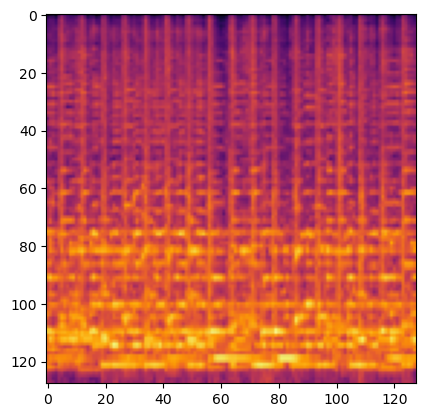

In [227]:
plt.imshow(images[5])

#### 2. Spectrogram Arrays

In addition to using images of the spectrograms to tune a image classification model, we're also going to use the spectrogram arrays, which are two dimensional to tune a cnn classification model. See below.

In [69]:
#Define functions to create mel spectrogram and add spectrogram arrays and classification labels to a list.

def create_mel_spectrogram(audio_file, n_mels=128, max_length=128):
    y, sr = librosa.load(audio_file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Resize spectrogram to a fixed shape
    if mel_spectrogram.shape[1] < max_length:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_length - mel_spectrogram.shape[1])), mode='constant')
    elif mel_spectrogram.shape[1] > max_length:
        mel_spectrogram = mel_spectrogram[:, :max_length]

    return mel_spectrogram

def create_mel_spectrogram_dataset(audio_dir, n_mels=128, max_length=128):
    mel_spectrogram_list = []
    labels = []

    for file in os.listdir(audio_dir):
        if file.endswith(".wav"):  
            audio_file = os.path.join(audio_dir, file)
            mel_spectrogram = create_mel_spectrogram(audio_file, n_mels, max_length)
            mel_spectrogram_list.append(mel_spectrogram)

            # Extract labels from the file name
            label = file.split("_")[0]  
            labels.append(label)

    # Convert the lists of spectrogram arrays and labels to NumPy arrays
    mel_spectrogram_array = np.array(mel_spectrogram_list)
    labels_array = np.array(labels)

    return mel_spectrogram_array, labels_array

In [70]:
#execute functions on audio files saved in audio folder
X_spec_array, y_spec_array = create_mel_spectrogram_dataset('audio', n_mels=128)

In [71]:
#check shape
X_spec_array[100].shape

(128, 128)

#### 2. Features

In addition to spectrograms, I extracted audio features from the .wav audio files. This code can be found in the 'Feature_Extraction' notebook. These numerical features are used below in various models including Random Forests, Logistic Regressions, and XG Boosted Ensemble models.

In [72]:
#import csv
features1 = pd.read_csv('features/sound_features.csv')

In [73]:
#view subset
features1.head()

,file_name,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,...,mfcc_8,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
0,Animal_MslenAGSsHo.wav,0.570271,0.581818,0.646618,0.706214,0.690292,0.635286,0.594778,0.521217,0.473431,...,1.489605,-18.214935,1.971242,135.999178,135.999178,0.022001,0.013036,0.026504,8.888500,105.570977
1,Animal_8QSJw4MEMo0.wav,0.367457,0.297988,0.262824,0.354224,0.363104,0.451306,0.337480,0.361378,0.399233,...,-18.555685,-33.325890,15.849258,172.265625,129.199219,0.066833,0.052632,0.077297,2.368649,4.665862
2,Vehicle_1rfS8uKqj4o.wav,0.488967,0.639262,0.614823,0.550539,0.471572,0.402641,0.442104,0.569618,0.425721,...,9.872471,-2.715639,11.963491,123.046875,129.199219,0.078130,0.063891,0.087431,0.928588,0.357901
3,Music_vWHSAicYrXs.wav,0.476637,0.587124,0.491797,0.487837,0.489465,0.413237,0.461874,0.413858,0.383470,...,19.983310,-1.135275,6.325337,161.499023,151.999081,0.130622,0.105235,0.133500,1.143295,0.276828
4,Speech_NAA575lzITk.wav,0.406786,0.400832,0.367696,0.380573,0.389452,0.362394,0.389288,0.410195,0.437171,...,-7.062017,-16.129002,-2.049819,123.046875,129.199219,0.092621,0.066790,0.144623,3.129942,10.512643


In [74]:
#view stats
features1.describe()

,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,...,mfcc_8,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
count,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,...,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3103.000000,3103.000000
mean,0.461338,0.466141,0.457171,0.462528,0.456627,0.459314,0.454816,0.450693,0.462792,0.463967,...,1.789601,-4.791835,1.629174,124.353336,124.538539,0.107715,0.086442,0.120145,2.892254,26.948656
std,0.120788,0.154006,0.154227,0.155304,0.155506,0.151845,0.157008,0.151945,0.152800,0.152933,...,10.497680,10.458382,8.364783,30.874825,16.159917,0.101731,0.085870,0.104554,3.976796,195.482651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-40.157597,-55.929787,-36.629757,0.000000,37.999770,0.000100,0.000000,0.000000,-2.652713,-1.861084
25%,0.372746,0.361272,0.349766,0.355664,0.345270,0.352259,0.341057,0.342288,0.357866,0.355606,...,-4.278479,-11.076328,-3.326695,103.359375,117.453835,0.032781,0.025052,0.042701,1.263350,0.617840
50%,0.462586,0.471639,0.458414,0.460356,0.453999,0.458781,0.455950,0.451374,0.467399,0.468425,...,2.169428,-4.826446,1.950603,123.046875,123.046875,0.078768,0.061968,0.094574,1.935615,2.821869
75%,0.555220,0.576939,0.570021,0.574452,0.570176,0.571155,0.569134,0.561076,0.574366,0.574044,...,8.634156,0.860950,6.786534,143.554688,129.199219,0.151753,0.121465,0.166275,3.091607,9.526589
max,0.786966,0.999620,0.977630,0.951524,0.986985,0.980538,1.000000,0.984928,0.975069,0.966289,...,45.098960,40.478374,34.542603,287.109375,287.109375,0.876853,0.849929,0.878556,71.398463,5445.673585


In [75]:
#Extract class labels from the audio file names and create label column
def extract_label(filename):
    return filename.split('_')[0]

features1['label'] = features1['file_name'].apply(extract_label)

In [76]:
features1.head()

,file_name,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,...,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Animal_MslenAGSsHo.wav,0.570271,0.581818,0.646618,0.706214,0.690292,0.635286,0.594778,0.521217,0.473431,...,-18.214935,1.971242,135.999178,135.999178,0.022001,0.013036,0.026504,8.888500,105.570977,Animal
1,Animal_8QSJw4MEMo0.wav,0.367457,0.297988,0.262824,0.354224,0.363104,0.451306,0.337480,0.361378,0.399233,...,-33.325890,15.849258,172.265625,129.199219,0.066833,0.052632,0.077297,2.368649,4.665862,Animal
2,Vehicle_1rfS8uKqj4o.wav,0.488967,0.639262,0.614823,0.550539,0.471572,0.402641,0.442104,0.569618,0.425721,...,-2.715639,11.963491,123.046875,129.199219,0.078130,0.063891,0.087431,0.928588,0.357901,Vehicle
3,Music_vWHSAicYrXs.wav,0.476637,0.587124,0.491797,0.487837,0.489465,0.413237,0.461874,0.413858,0.383470,...,-1.135275,6.325337,161.499023,151.999081,0.130622,0.105235,0.133500,1.143295,0.276828,Music
4,Speech_NAA575lzITk.wav,0.406786,0.400832,0.367696,0.380573,0.389452,0.362394,0.389288,0.410195,0.437171,...,-16.129002,-2.049819,123.046875,129.199219,0.092621,0.066790,0.144623,3.129942,10.512643,Speech


In [284]:
#View label split. Dataset is fairly balanced.
features1['label'].value_counts(normalize=True)

label
Animal            0.214240
Music             0.211662
Speech            0.207152
Vehicle           0.203930
Natural Sounds    0.163015
Name: proportion, dtype: float64

In compiling the features dataset, I included both the global average and averages for each pitch class for features where this is relevant, such as chroma_stft which computes a chromagram from a given audio file or spectrogram. Below I split the dataset into two datagframes. One with 65 features that excludes the global averages and one with 16 features that includes only the global averages for features that have both. We'll train models with both to to evaluate whether incorporating additional features enhances the model's performance or introduces excessive multicollinearity. This analysis will help us understand the impact of increased feature complexity on the model's predictive capabilities.

In [78]:
to_drop = features1.filter(like='global')
featuresdf = features1.drop(columns=to_drop)
featuresdf.head()

,file_name,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,...,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Animal_MslenAGSsHo.wav,0.581818,0.646618,0.706214,0.690292,0.635286,0.594778,0.521217,0.473431,0.431605,...,-18.214935,1.971242,135.999178,135.999178,0.022001,0.013036,0.026504,8.888500,105.570977,Animal
1,Animal_8QSJw4MEMo0.wav,0.297988,0.262824,0.354224,0.363104,0.451306,0.337480,0.361378,0.399233,0.456999,...,-33.325890,15.849258,172.265625,129.199219,0.066833,0.052632,0.077297,2.368649,4.665862,Animal
2,Vehicle_1rfS8uKqj4o.wav,0.639262,0.614823,0.550539,0.471572,0.402641,0.442104,0.569618,0.425721,0.387548,...,-2.715639,11.963491,123.046875,129.199219,0.078130,0.063891,0.087431,0.928588,0.357901,Vehicle
3,Music_vWHSAicYrXs.wav,0.587124,0.491797,0.487837,0.489465,0.413237,0.461874,0.413858,0.383470,0.354716,...,-1.135275,6.325337,161.499023,151.999081,0.130622,0.105235,0.133500,1.143295,0.276828,Music
4,Speech_NAA575lzITk.wav,0.400832,0.367696,0.380573,0.389452,0.362394,0.389288,0.410195,0.437171,0.434343,...,-16.129002,-2.049819,123.046875,129.199219,0.092621,0.066790,0.144623,3.129942,10.512643,Speech


In [79]:
featuresdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            3104 non-null   object 
 1   chroma_stft_1        3104 non-null   float64
 2   chroma_stft_2        3104 non-null   float64
 3   chroma_stft_3        3104 non-null   float64
 4   chroma_stft_4        3104 non-null   float64
 5   chroma_stft_5        3104 non-null   float64
 6   chroma_stft_6        3104 non-null   float64
 7   chroma_stft_7        3104 non-null   float64
 8   chroma_stft_8        3104 non-null   float64
 9   chroma_stft_9        3104 non-null   float64
 10  chroma_stft_10       3104 non-null   float64
 11  chroma_stft_11       3104 non-null   float64
 12  chroma_stft_12       3104 non-null   float64
 13  chroma_cens_1        3104 non-null   float64
 14  chroma_cens_2        3104 non-null   float64
 15  chroma_cens_3        3104 non-null   f

In [80]:
to_drop = features1.filter(regex=r'\d', axis=1)
features_global = features1.drop(columns=to_drop)

In [81]:
features_global.head()

,file_name,global_mean_chroma_stft,global_mean_cens,global_mean_cqt,spectral_centroid,spectral_bandwidth,global_mean_spectral_contrast,spectral_rolloff,zero_crossing_rate,global_mean_mfcc,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Animal_MslenAGSsHo.wav,0.570271,0.286902,0.758899,2775.597177,2287.612220,20.863956,5156.845093,0.201026,-25.498838,135.999178,135.999178,0.022001,0.013036,0.026504,8.888500,105.570977,Animal
1,Animal_8QSJw4MEMo0.wav,0.367457,0.268536,0.492366,1956.948318,1079.716934,23.943070,3153.040485,0.174449,-26.068579,172.265625,129.199219,0.066833,0.052632,0.077297,2.368649,4.665862,Animal
2,Vehicle_1rfS8uKqj4o.wav,0.488967,0.193427,0.338366,1960.723305,2209.537201,20.667736,4538.433134,0.056245,-8.074483,123.046875,129.199219,0.078130,0.063891,0.087431,0.928588,0.357901,Vehicle
3,Music_vWHSAicYrXs.wav,0.476637,0.253608,0.481798,2297.931623,2509.926367,24.466005,5509.302494,0.093133,7.248433,161.499023,151.999081,0.130622,0.105235,0.133500,1.143295,0.276828,Music
4,Speech_NAA575lzITk.wav,0.406786,0.273475,0.539345,2666.463016,2409.911877,21.048115,5219.528531,0.169509,-21.335762,123.046875,129.199219,0.092621,0.066790,0.144623,3.129942,10.512643,Speech


In [82]:
features_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   file_name                      3104 non-null   object 
 1   global_mean_chroma_stft        3104 non-null   float64
 2   global_mean_cens               3104 non-null   float64
 3   global_mean_cqt                3104 non-null   float64
 4   spectral_centroid              3104 non-null   float64
 5   spectral_bandwidth             3104 non-null   float64
 6   global_mean_spectral_contrast  3104 non-null   float64
 7   spectral_rolloff               3104 non-null   float64
 8   zero_crossing_rate             3104 non-null   float64
 9   global_mean_mfcc               3104 non-null   float64
 10  beat_track_tempo               3104 non-null   float64
 11  feature_tempo                  3104 non-null   float64
 12  mean_rms                       3104 non-null   f

In [83]:
features_global.dropna(inplace=True)
featuresdf.dropna(inplace=True)

## Preprocessing

#### 1. Spectrogram Images

In [228]:
#train_test split image dataset
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=SEED)

In [229]:
#one hot encode labels for train set
labels_unique = list(set(labels))
label_to_index = {label: index for index, label in enumerate(labels_unique)}
y_train_num_labels = [label_to_index[label] for label in y_train_img]
y_train_img_onehot = to_categorical(y_train_num_labels)

In [230]:
#one hot encode labels for test set
y_test_num_labels = [label_to_index[label] for label in y_test_img]
y_test_img_onehot = to_categorical(y_test_num_labels)

In [231]:
#set as arrays
X_train_img = np.array(X_train_img)
X_test_img = np.array(X_test_img)

In [232]:
#check shape of X
np.shape(X_train_img)

(2793, 128, 128, 3)

In [233]:
#check shape y
np.shape(y_train_img_onehot)

(2793, 5)

#### 2. Spectrogram Audio Arrays

In [90]:
#train_test array data set
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(X_spec_array, y_spec_array, test_size=0.1,
                                                                    stratify=y_spec_array, random_state=SEED)

In [91]:
#one hot encode labels for train set
labels_unique = list(set(y_spec_array))
label_to_index = {label: index for index, label in enumerate(labels_unique)}
y_train_arr_onehot_num = [label_to_index[label] for label in y_train_arr]
y_train_arr_onehot = to_categorical(y_train_arr_onehot_num)

In [92]:
#one hot encode labels for test set
y_test_arr_num_labels = [label_to_index[label] for label in y_test_arr]
y_test_arr_onehot = to_categorical(y_test_arr_num_labels)

In [93]:
#reshape for use in CNN model
X_train_arr = X_train_arr.reshape(X_train_arr.shape[0], 128, 128, 1)

In [94]:
#check shape
X_train_arr.shape

(2793, 128, 128, 1)

In [95]:
#reshape for use in cnn model
X_test_arr = X_test_arr.reshape(X_test_arr.shape[0], 128, 128, 1)

In [96]:
#check shape
X_test_arr.shape

(311, 128, 128, 1)

In [98]:
#check shape
y_train_arr_onehot.shape

(2793, 5)

#### 3. Features

In [181]:
#train_test split feature data
X_feat = featuresdf.drop(columns=['file_name', 'label'])
y_feat = featuresdf['label']
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_feat, y_feat, random_state=SEED)

In [182]:
X_featglobal = features_global.drop(columns=['file_name', 'label'])
y_featglobal = features_global['label']
X_train_featglobal, X_test_featglobal, y_train_featglobal, y_test_featglobal = train_test_split(X_featglobal, y_featglobal, random_state=SEED)

## Modeling w/ Spectrograms

#### CNN - Image Classification

In [245]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,         
                               restore_best_weights=True) 

In [246]:
model01 = Sequential()

#layer one
model01.add(Conv2D(filters=32,
                        kernel_size=(5, 5),
                        input_shape=(128, 128, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))

#layer two
model01.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))

#layer three
#model02.add(Conv2D(filters=64,
                        #kernel_size=(4, 4)))
#model02.add(BatchNormalization())
#model02.add(ReLU())
#model02.add(MaxPooling2D(pool_size=(2, 2)))


# transition to dense fully-connected part of network
model01.add(GlobalAveragePooling2D())

#add dropout layer
#model02.add(Dropout(0.5))
#output layer
model01.add(Dense(5, activation='softmax'))

In [247]:
model01.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy',  metrics=['accuracy'])

In [250]:
history01 = model01.fit(X_train_img, y_train_img_onehot, epochs=30, batch_size=32, verbose = 2, 
                        validation_split=.2)

Epoch 1/30
70/70 - 12s - loss: 1.1460 - accuracy: 0.5403 - val_loss: 2.3909 - val_accuracy: 0.2451 - 12s/epoch - 170ms/step
Epoch 2/30
70/70 - 12s - loss: 1.1091 - accuracy: 0.5658 - val_loss: 2.7086 - val_accuracy: 0.2057 - 12s/epoch - 172ms/step
Epoch 3/30
70/70 - 13s - loss: 1.0910 - accuracy: 0.5739 - val_loss: 2.7625 - val_accuracy: 0.2236 - 13s/epoch - 180ms/step
Epoch 4/30
70/70 - 12s - loss: 1.0903 - accuracy: 0.5833 - val_loss: 2.6637 - val_accuracy: 0.2308 - 12s/epoch - 172ms/step
Epoch 5/30
70/70 - 12s - loss: 1.0745 - accuracy: 0.5828 - val_loss: 2.0209 - val_accuracy: 0.3077 - 12s/epoch - 172ms/step
Epoch 6/30
70/70 - 12s - loss: 1.0677 - accuracy: 0.5837 - val_loss: 1.3368 - val_accuracy: 0.4419 - 12s/epoch - 175ms/step
Epoch 7/30
70/70 - 12s - loss: 1.0480 - accuracy: 0.6025 - val_loss: 1.4019 - val_accuracy: 0.3721 - 12s/epoch - 178ms/step
Epoch 8/30
70/70 - 14s - loss: 1.0513 - accuracy: 0.6043 - val_loss: 1.3982 - val_accuracy: 0.4097 - 14s/epoch - 206ms/step
Epoch 9/

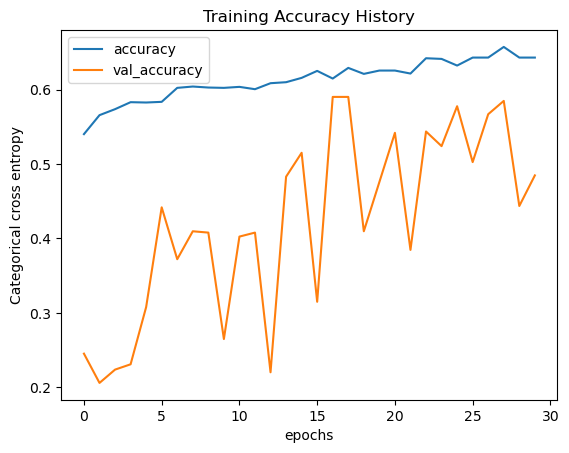

In [251]:
train_history = pd.DataFrame(history01.history)
train_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training Accuracy History')
plt.show()

In [253]:
cnn_img_train_acc = history01.history['accuracy'][-1]
cnn_img_val_acc = history01.history['val_accuracy'][-1]

### CNN -  Spec Arrays

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,         
                               restore_best_weights=True) 

In [112]:
model02 = Sequential()

#layer one
model02.add(Conv2D(filters=32,
                        kernel_size=(5, 5),
                        input_shape=(128, 128, 1)))
model02.add(BatchNormalization())
model02.add(ReLU())
model02.add(MaxPooling2D(pool_size=(2, 2)))

#layer two
model02.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model02.add(BatchNormalization())
model02.add(ReLU())
model02.add(MaxPooling2D(pool_size=(2, 2)))

#layer three
#model02.add(Conv2D(filters=64,
                        #kernel_size=(4, 4)))
#model02.add(BatchNormalization())
#model02.add(ReLU())
#model02.add(MaxPooling2D(pool_size=(2, 2)))


# transition to dense fully-connected part of network
model02.add(GlobalAveragePooling2D())

#add dropout layer
#model02.add(Dropout(0.5))
#output layer
model02.add(Dense(5, activation='softmax'))

In [113]:
model02.compile(optimizer=Adam(learning_rate = 0.005), loss='categorical_crossentropy',  metrics=['accuracy'])

In [115]:
history02 = model02.fit(X_train_arr, y_train_arr_onehot, epochs=20, batch_size=32, verbose = 2, 
                        validation_split=.2)

Epoch 1/20
70/70 - 10s - loss: 1.2524 - accuracy: 0.4816 - val_loss: 3.2851 - val_accuracy: 0.2737 - 10s/epoch - 143ms/step
Epoch 2/20
70/70 - 10s - loss: 1.2104 - accuracy: 0.5134 - val_loss: 1.9315 - val_accuracy: 0.2540 - 10s/epoch - 143ms/step
Epoch 3/20
70/70 - 10s - loss: 1.2007 - accuracy: 0.5197 - val_loss: 2.5296 - val_accuracy: 0.1950 - 10s/epoch - 143ms/step
Epoch 4/20
70/70 - 10s - loss: 1.1893 - accuracy: 0.5206 - val_loss: 1.4300 - val_accuracy: 0.3936 - 10s/epoch - 144ms/step
Epoch 5/20
70/70 - 10s - loss: 1.1883 - accuracy: 0.5255 - val_loss: 1.7556 - val_accuracy: 0.3023 - 10s/epoch - 144ms/step
Epoch 6/20
70/70 - 10s - loss: 1.1643 - accuracy: 0.5452 - val_loss: 1.2676 - val_accuracy: 0.4902 - 10s/epoch - 147ms/step
Epoch 7/20
70/70 - 11s - loss: 1.1651 - accuracy: 0.5421 - val_loss: 3.4829 - val_accuracy: 0.2809 - 11s/epoch - 158ms/step
Epoch 8/20
70/70 - 13s - loss: 1.1715 - accuracy: 0.5474 - val_loss: 7.4880 - val_accuracy: 0.2165 - 13s/epoch - 182ms/step
Epoch 9/

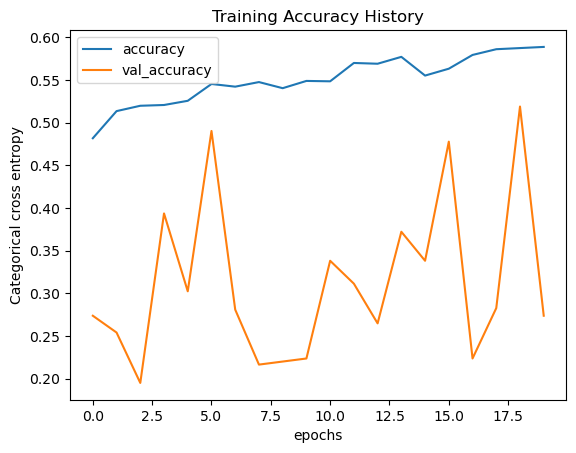

In [116]:
train_history = pd.DataFrame(history02.history)
train_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training Accuracy History')
plt.show()

## Modeling w/ Extracted Features

1. Random Forest
2. Logistic Regression
3. AdaBoost Classifier
4. XGBoost Classifier

#### 1. Random Forest

In [268]:
rfc = RandomForestClassifier(random_state=SEED)
rfc_model_pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components = 7)), ('rfc', rfc)])

In [269]:
rfc_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [270]:
rfc_model_pipe.score(X_train_feat, y_train_feat)

1.0

In [262]:
params_rfc = {
    'rfc__n_estimators': [100, 200],
    'rfc__min_samples_split': [2, 3, 4],
    'rfc__min_samples_leaf': [3, 4],
    'rfc__max_depth': [3, 7, 10],
    'rfc__criterion': ['gini'],
    'pca__n_components': [10, 25, 50]}

rfc_gs_cv = GridSearchCV(estimator=rfc_model_pipe, param_grid=params_rfc,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
rfc_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(rfc_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'pca__n_components': 50, 'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200}
Time taken: 144.8003978729248 seconds


In [263]:
rfc_best_model = rfc_gs_cv.best_estimator_
rfc_best_train_score = rfc_gs_cv.cv_results_['mean_train_score'][rfc_gs_cv.best_index_]
rfc_best_test_score = rfc_gs_cv.best_score_

print('RFC Best Model:', rfc_best_model)
print("RFC Best Model Train Accuracy Score:", rfc_best_train_score)
print("RFC Best Model Test Accuracy Score:", rfc_best_test_score)

RFC Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        n_estimators=200, random_state=42))])
RFC Best Model Train Accuracy Score: 0.943489789316725
RFC Best Model Test Accuracy Score: 0.614951224919632


In [264]:
#Let's try fitting rfc on dataset with fewer features 
#(relevant features are reduced to global average as opposed to per pitch class average)
rfc_model_pipe.fit(X_train_featglobal, y_train_featglobal)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('rfc', RandomForestClassifier(random_state=42))])

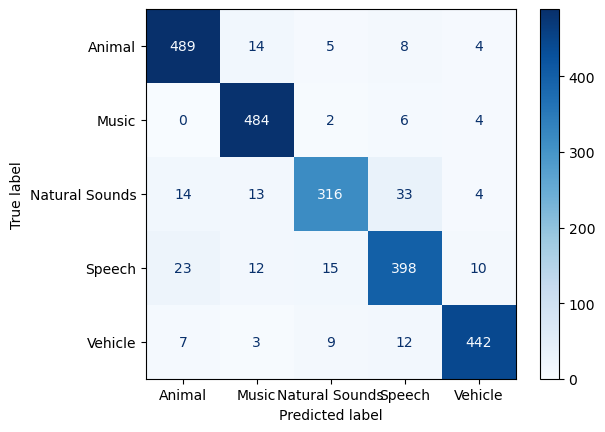

In [271]:
#display confusion matrix
ConfusionMatrixDisplay.from_estimator(rfc_best_model, X_train_feat, y_train_feat, cmap='Blues')

#### 2. Logistic Regression

In [137]:
lgr_model_pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components = 10)), ('model', LogisticRegression(solver='newton-cg', random_state=SEED))])
lgr_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model',
                 LogisticRegression(random_state=42, solver='newton-cg'))])

In [129]:
lgr_model_pipe.score(X_train_feat, y_train_feat)

0.6489041684572411

In [134]:
params_lgr = {
    'model__penalty': ['l2', 'l1', None],
    'model__tol': [0.0001, .001],
    'model__C': [.05, .1, 1],
    'model__max_iter': [100, 200],
    'model__solver': ['newton-cg', 'sag', 'saga'],
    'pca__n_components': [10, 25, 50]}

lgr_gs_cv = GridSearchCV(estimator=lgr_model_pipe, param_grid=params_lgr,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
lgr_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(lgr_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio 

{'model__C': 1, 'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'saga', 'model__tol': 0.0001, 'pca__n_components': 50}
Time taken: 88.017813205719 seconds


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [135]:
lgr_best_model = lgr_gs_cv.best_estimator_
lgr_best_train_score = lgr_gs_cv.cv_results_['mean_train_score'][lgr_gs_cv.best_index_]
lgr_best_test_score = lgr_gs_cv.best_score_

print('Log Regression Best Model:', lgr_best_model)
print("Log Regression Best Model Train Accuracy Score:", lgr_best_train_score)
print("Log Regression Best Model Test Accuracy Score:", lgr_best_test_score)

Log Regression Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('model',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='saga'))])
Log Regression Best Model Train Accuracy Score: 0.6570673559459478
Log Regression Best Model Test Accuracy Score: 0.6136581310276022


In [139]:
#Let's try fitting rfc on dataset with fewer features 
#(relevant features are reduced to global average as opposed to per pitch class average)
lgr_model_pipe.fit(X_train_featglobal, y_train_featglobal)
lgr_model_pipe.score(X_train_featglobal, y_train_featglobal)

0.5487752470992694

In [144]:
params_lgr = {
    'model__penalty': ['l2', 'l1', None],
    'model__tol': [0.0001, .001],
    'model__C': [.05, .1, 1],
    'model__max_iter': [100, 200],
    'model__solver': ['newton-cg', 'sag', 'saga'],
    'pca__n_components': [3, 10, 16]}

lgr_gs_cv = GridSearchCV(estimator=lgr_model_pipe, param_grid=params_lgr,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
lgr_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(lgr_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio para

{'model__C': 0.1, 'model__max_iter': 200, 'model__penalty': 'l1', 'model__solver': 'saga', 'model__tol': 0.0001, 'pca__n_components': 16}
Time taken: 30.38551902770996 seconds


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
216 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilykrueger/anaconda3/envs/le

In [145]:
lgr_best_model = lgr_gs_cv.best_estimator_
lgr_best_train_score = lgr_gs_cv.cv_results_['mean_train_score'][lgr_gs_cv.best_index_]
lgr_best_test_score = lgr_gs_cv.best_score_

print('Log Regression Best Model:', lgr_best_model)
print("Log Regression Best Model Train Accuracy Score:", lgr_best_train_score)
print("Log Regression Best Model Test Accuracy Score:", lgr_best_test_score)

Log Regression Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16)),
                ('model',
                 LogisticRegression(C=0.1, max_iter=200, penalty='l1',
                                    random_state=42, solver='saga'))])
Log Regression Best Model Train Accuracy Score: 0.5524243310490294
Log Regression Best Model Test Accuracy Score: 0.5440433433100543


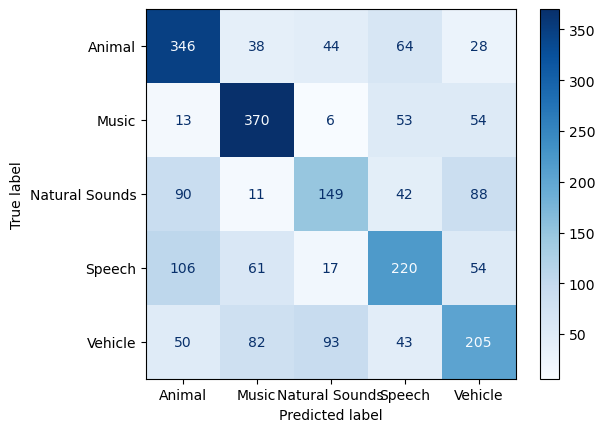

In [272]:
#display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgr_best_model, X_train_feat, y_train_feat, cmap='Blues')

#### 3. AdaBoost Classifier

Per the documentation, An AdaBoostclassifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [218]:
ada_boost_model = AdaBoostClassifier(n_estimators=25, estimator=DecisionTreeClassifier(),
                                     learning_rate=0.5, random_state=SEED)

In [219]:
ada_model_pipe = Pipeline([('scaler', StandardScaler()),
                           ('pca', PCA(n_components=40)),
                           ('model', ada_boost_model)])
ada_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=40)),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                    learning_rate=0.5, n_estimators=25,
                                    random_state=42))])

In [220]:
ada_model_pipe.score(X_train_feat, y_train_feat)

1.0

In [221]:
params_ada = {
    'pca__n_components': [20, 40, 50],
    'model__learning_rate': [0.1, 0.5, 1],
    'model__n_estimators': [50, 100],
    'model__estimator': [DecisionTreeClassifier(), RandomForestClassifier()],
    'model__estimator__max_depth': [3, 7, 10]
}

ada_gs_cv = GridSearchCV(estimator=ada_model_pipe, param_grid=params_ada,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
ada_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(ada_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'model__estimator': RandomForestClassifier(), 'model__estimator__max_depth': 10, 'model__learning_rate': 0.1, 'model__n_estimators': 50, 'pca__n_components': 50}
Time taken: 2144.7437312602997 seconds


In [223]:
ada_best_model = ada_gs_cv.best_estimator_
ada_best_train_score = ada_gs_cv.cv_results_['mean_train_score'][ada_gs_cv.best_index_]
ada_best_test_score = ada_gs_cv.best_score_

print('AdaBoost Best Model:', ada_best_model)
print("AdaBoost Best Model Train Accuracy Score:", ada_best_train_score)
print("AdaBoost Best Model Test Accuracy Score:", ada_best_test_score)

AdaBoost Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('model',
                 AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=10),
                                    learning_rate=0.1, random_state=42))])
AdaBoost Best Model Train Accuracy Score: 0.9959174437952679
AdaBoost Best Model Test Accuracy Score: 0.624400288216384


#### 4. XG Boost Classifier

XGBoost is a gradient boosting library. It provides a parallel tree boosting (also known as GBDT, GBM) that can solve various DS problems.

In [275]:
#Need to convert categorical labels to numbers for use in XG Boost
#instantiate label encoder
label_encoder = LabelEncoder()

#fit transform train
y_train_feat_encoded = label_encoder.fit_transform(y_train_feat)

#transform test
y_test_feat_encoded = label_encoder.transform(y_test_feat)

In [276]:
xg_boost_model = xgboost.XGBClassifier(random_state=SEED, booster='gbtree', objective='multi:softmax', num_class=len(label_encoder.classes_))

In [277]:
xg_model_pipe = Pipeline([('scaler', StandardScaler()), 
                           ('model', xg_boost_model)])
xg_model_pipe.fit(X_train_feat, y_train_feat_encoded)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_class=5, num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [278]:
xg_model_pipe.score(X_train_feat, y_train_feat_encoded)

1.0

In [279]:
params_xg = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
}

xg_gs_cv = GridSearchCV(estimator=xg_model_pipe, param_grid=params_xg,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
xg_gs_cv.fit(X_train_feat, y_train_feat_encoded)
end_time = time.time()

print(xg_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}
Time taken: 2328.490368127823 seconds


In [280]:
xg_best_model = xg_gs_cv.best_estimator_
xg_best_train_score = xg_gs_cv.cv_results_['mean_train_score'][xg_gs_cv.best_index_]
xg_best_test_score = xg_gs_cv.best_score_

print('Log Regression Best Model:', xg_best_model)
print("Log Regression Best Model Train Accuracy Score:", xg_best_train_score)
print("Log Regression Best Model Test Accuracy Score:", xg_best_test_score)

Log Regression Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.8,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=No

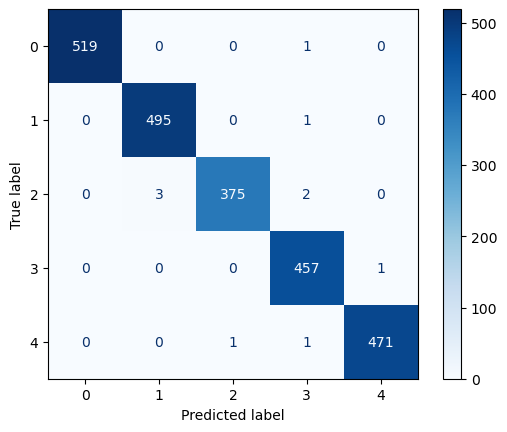

In [281]:
#display confusion matrix
ConfusionMatrixDisplay.from_estimator(xg_best_model, X_train_feat, y_train_feat_encoded, cmap='Blues')

### Model Comparison

In [265]:
#Creat bar chart to compare train test scores
model_names = ['Random Forest', 'Logistic Regression', 'AdaBoost Classifier', 
               'XGBoost Classifier', 'CNN Image Classification Model']

train_scores = [rfc_best_train_score, lgr_best_train_score, ada_best_train_score, xg_best_train_score,cnn_img_train_acc]

test_scores = [rfc_best_test_score, lgr_best_test_score, ada_best_test_score, xg_best_test_score, cnn_img_val_acc]

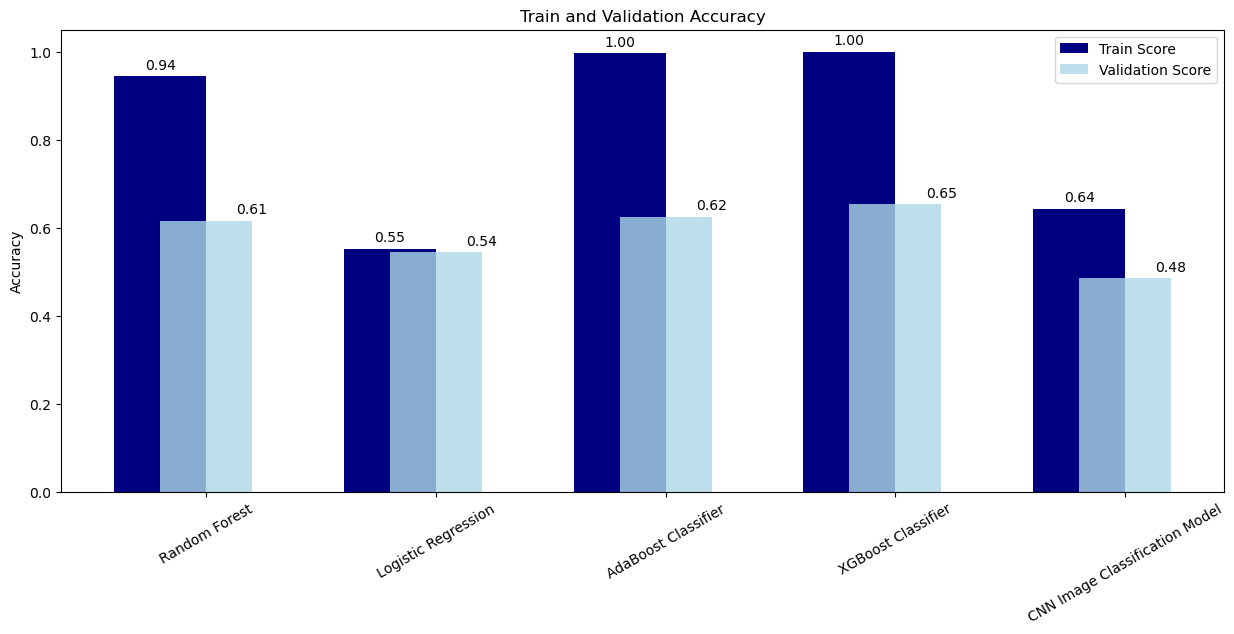

In [266]:
# Create bar chart comparing test and val scores for each model
bar_width = 0.4
fig, ax = plt.subplots(figsize=(15, 6))

# Create x labels
x = range(len(model_names))

# Plot scores
train_bars = ax.bar(x, train_scores, bar_width, label='Train Score', color='navy')
test_bars = ax.bar(x, test_scores, bar_width, label='Validation Score', color='lightblue', alpha=0.8, align='edge')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(model_names, rotation=30)

#Label bars
for i, (train_bar, test_bar) in enumerate(zip(train_bars, test_bars)):
    ax.text(i, train_bar.get_height() + 0.01, f'{train_scores[i]:.2f}', ha='center', va='bottom')
    ax.text(i + bar_width, test_bar.get_height() + 0.01, f'{test_scores[i]:.2f}', ha='center', va='bottom')

ax.legend()
ax.set_ylabel('Accuracy')
ax.set_title('Train and Validation Accuracy')

plt.show()

### Evaluate Model on Unseen Test Data

In [298]:
#At this point in time (11/9/23) xg model is producing best validation score. see chart above
best_model = xg_best_model

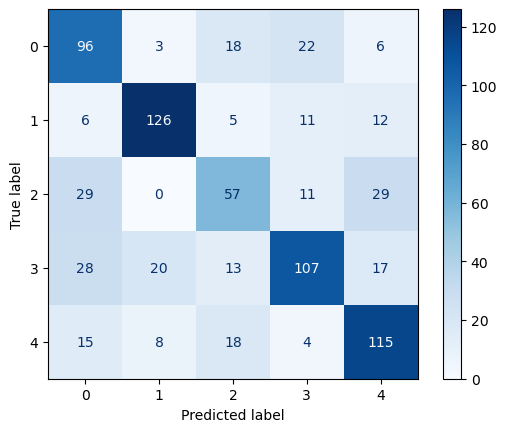

In [300]:
display = ConfusionMatrixDisplay.from_estimator(best_model, X_test_feat, y_test_feat_encoded, cmap='Blues')

In [301]:
best_model.score(X_test_feat, y_test_feat_encoded)

0.645618556701031

In [307]:
y_pred = best_model.predict(X_test_feat)

In [308]:
precision_score(y_test_feat_encoded, y_pred, average='weighted')

0.6489862364994136

In [309]:
recall_score(y_test_feat_encoded, y_pred, average='weighted')

0.645618556701031

In [310]:
f1_score(y_test_feat_encoded, y_pred, average='weighted')

0.6444181700689341